In [1]:
import torch
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)

## Define Data

<Figure size 200x200 with 0 Axes>

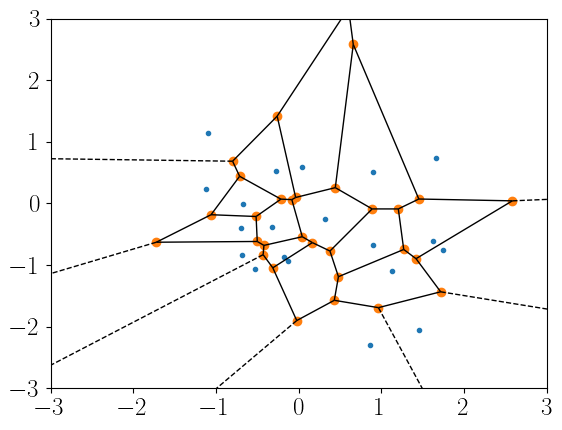

In [2]:
# load data from file
data = np.load('training_data.npy')
N, dim = data.shape

# define voronoi tesselation
vor = Voronoi(data)

# plot
plt.figure(figsize=(2,2))
fig = voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define models

In [3]:
from score_models import VE, GMM_score_TikhonovRegularizedTheory

# define forward process
model = VE()
model.eps = 0.

# define regularized GMM
gmm_train = GMM_score_TikhonovRegularizedTheory(torch.tensor(data, dtype=torch.float32), model.marginal_prob_mean, \
                                   model.marginal_prob_std, model.diffusion_coeff, constant=0.1)

# test network
dim = data.shape[1]
rand_x = torch.randn(1000, dim).to(device)
rand_t = torch.rand(1,) * torch.ones((1000,1))
print(gmm_train(rand_x, rand_t[:,0]).shape)

torch.Size([1000, 2])


## Compute trajectories

(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)


<Figure size 640x480 with 0 Axes>

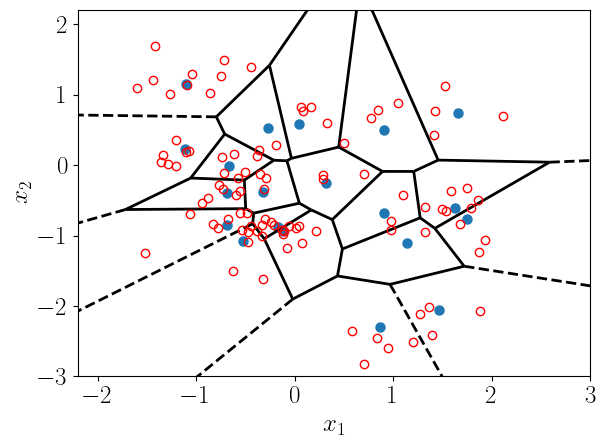

<Figure size 640x480 with 0 Axes>

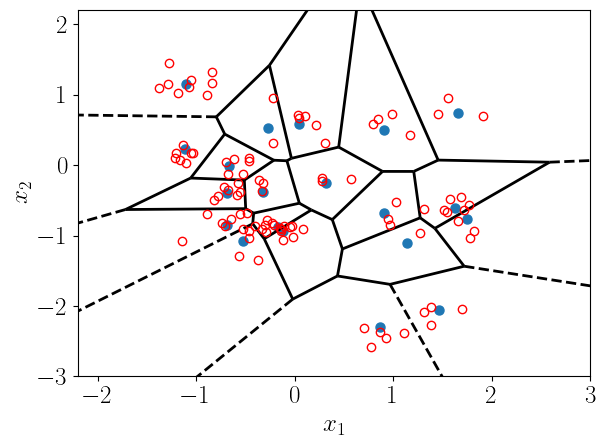

<Figure size 640x480 with 0 Axes>

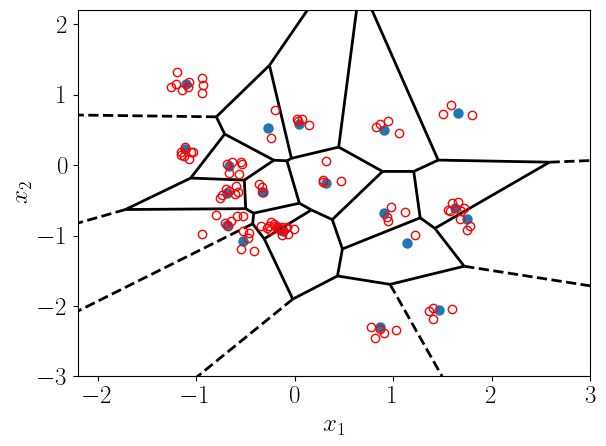

<Figure size 640x480 with 0 Axes>

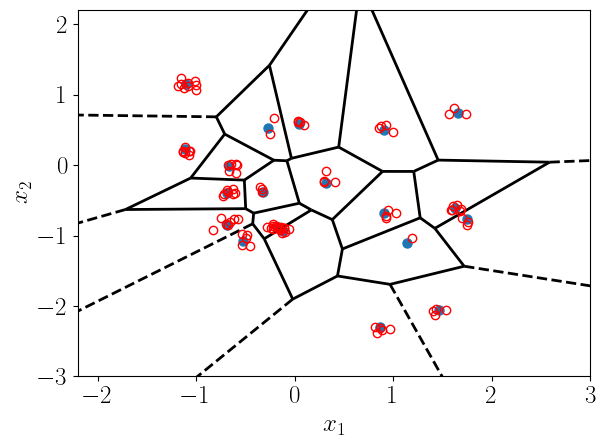

<Figure size 640x480 with 0 Axes>

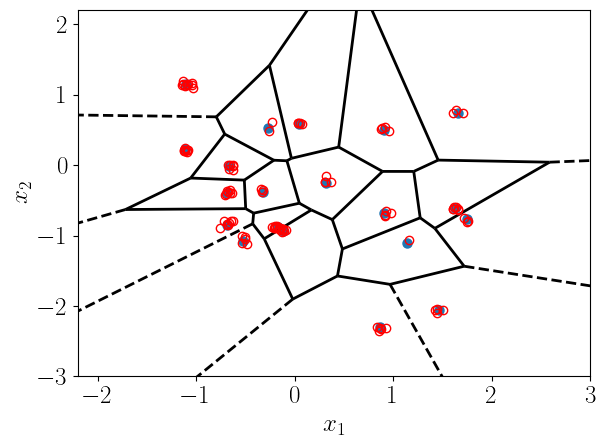

<Figure size 640x480 with 0 Axes>

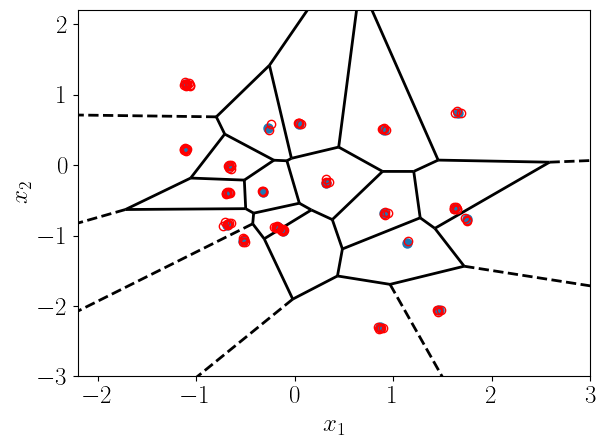

<Figure size 640x480 with 0 Axes>

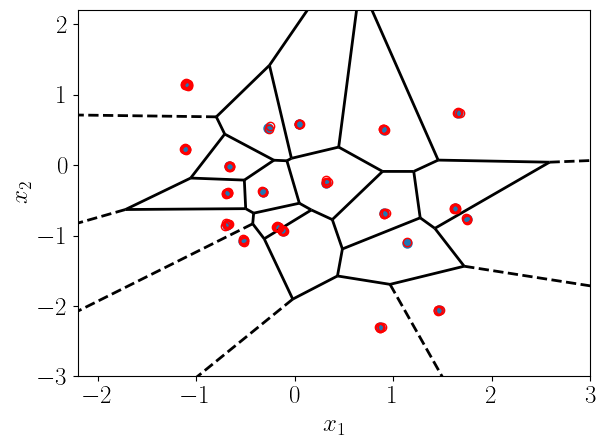

<Figure size 640x480 with 0 Axes>

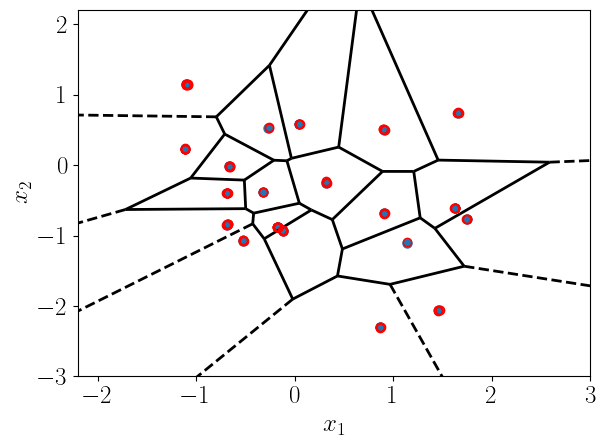

<Figure size 640x480 with 0 Axes>

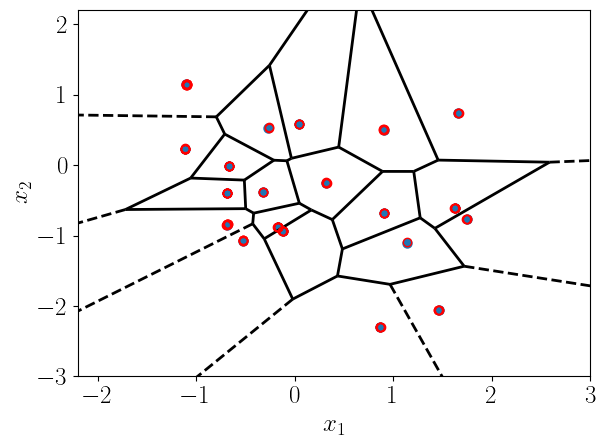

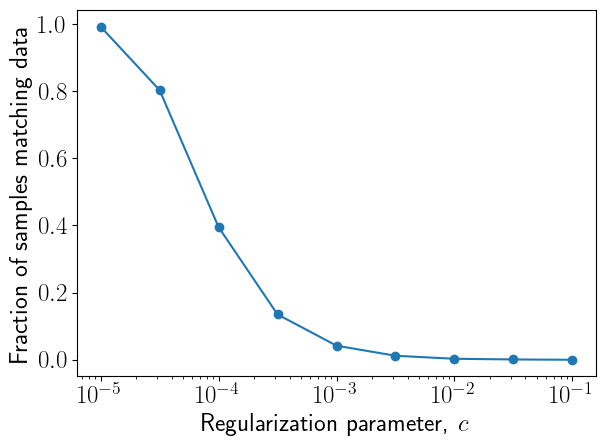

In [5]:
# define latent samples
batch_size = 1000
latents = torch.randn(batch_size, dim).to(device)

# define regularization parameter constants
constant_vect = torch.logspace(-1,-5,9) #[0.1,0.01,0.001,1e-4,1e-5] #[0.1,0.05,0.01,0.005,0.001,1e-4,1e-5]

# define array to store number of collapsed points
count_const_vect = torch.zeros(len(constant_vect))

# define number of points for plotting
plotting_pts = 100
tolerance = 1e-2

folder = 'figures/VE_Tikhonov'
# create folder to save results if it doesn't exixt
import os
if not os.path.exists(folder):
    os.makedirs(folder)

for (kk,const) in enumerate(constant_vect):

    # define GMM
    gmm_train = GMM_score_TikhonovRegularizedTheory(torch.tensor(data, dtype=torch.float32), model.marginal_prob_mean, \
                                       model.marginal_prob_std, model.diffusion_coeff, constant=const)

    # evaluate ODE and SDE paths
    GMM_t, GMM_x = model.ODEsampler(gmm_train, latents, T0=model.T, T1=0.0)
    final_pts = GMM_x[:,:,-1]

    # plot final points
    plt.figure()
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
    plt.plot(final_pts[:plotting_pts,0], final_pts[:plotting_pts,1], 'or', mfc='none')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-2.2,3)
    plt.ylim(-3,2.2)
    plt.tight_layout()
    #plt.savefig(folder+'/finalpoints_const_'+str(round(const.item(),6))+'.pdf')

    # check how close each point is to a data point
    count = 0
    for i in range(batch_size):
        dist = torch.sqrt(torch.sum((final_pts[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))
        if torch.min(dist) < tolerance:
            count += 1
    count_const_vect[kk] = count/batch_size

# Plot the fraction of points collapsing to data
plt.figure()
plt.semilogx(constant_vect, count_const_vect, '-o')
plt.xlabel(r'Regularization parameter, $c$')
plt.ylabel(r'Fraction of samples matching data')
plt.tight_layout()
#plt.savefig(folder+'/eps_effect.pdf')

### Plot convergence

In [ ]:
# compute expected convergence rate
true_rate = model.marginal_prob_std(torch.tensor(GMM_t))

plt.figure()
for i in range(batch_size):
    # compute distance to final point
    res_i = GMM_x[i,:,:]
    dist = torch.sqrt(torch.sum((res_i - res_i[:,-1][:,np.newaxis])**2, axis=0))
    plt.loglog(GMM_t, dist, '-r', alpha=0.8)
plt.loglog(GMM_t, 2*true_rate, '--k', label = '$\mathcal{O}(\sigma(t))$')
plt.xlabel('Time $t$')
plt.ylabel('$|x(t) - x^*|_2$')
plt.legend()
plt.xlim(1e-5,1)
plt.tight_layout()
#plt.savefig(folder+'/exponential_convergence.pdf')
plt.show()